<a href="https://colab.research.google.com/github/dacado0122-create/Colab/blob/main/trabajo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade pip
!pip install phiflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for phiflow: filename=phiflow-3.4.0-py3-none-any.whl size=239049 sha256=3b3c29f63a03162499c26e6f9aa426c80a24b37aba4b972b062952114621af64
  Stored in directory: /root/.cache/pip/wheels/e1/01/57/99aaeb0297ecc2d43bab373e905e5d73be8745183fc5bc47e7
  Created wheel for phiml: filename=phiml-1.14.3-py3-none-any.whl size=372948 sha256=58eec8c18ece30dfd69c98c846a591f7d50e8287673eec5d3ceaecb95ea22e3b
  Stored in directory: /root/.cache/pip/wheels/5d/c0/0a/baebe7f2167ea90c597a14b27789ee5804d16a62ae16

**codigo 1.1**

Simulación completada
Tensor Ground Truth: (20, 128, 128)
dt = 1.526e-02
dt máximo CFL = 1.526e-02
Tiempo de cómputo: 0.023 s


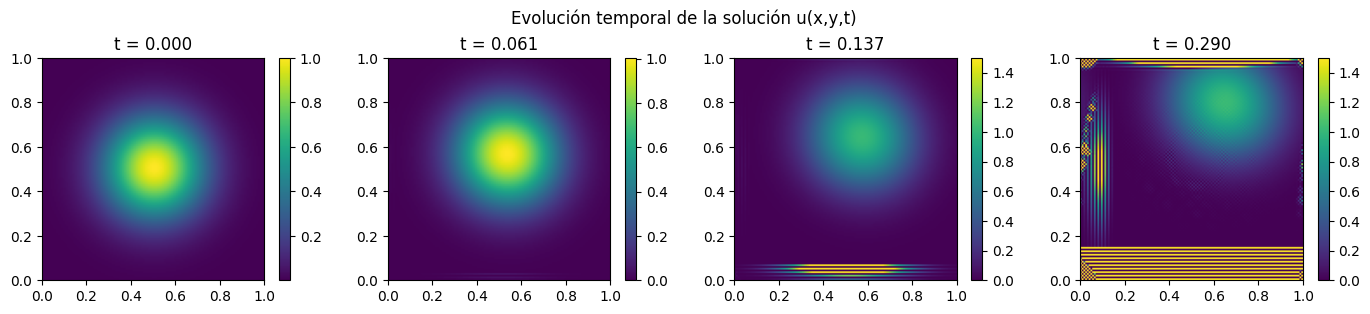


Error L2 respecto a referencia N=256:
N= 32  Error L2 = 1.037e+00
N= 64  Error L2 = 1.025e+00
N=128  Error L2 = 9.904e-01


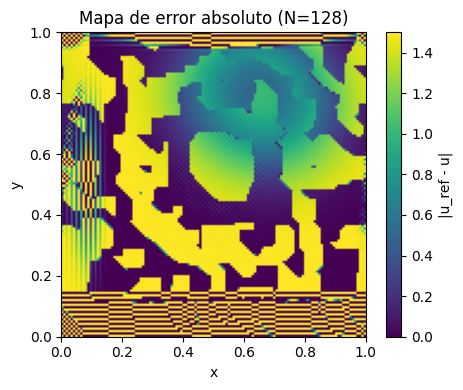

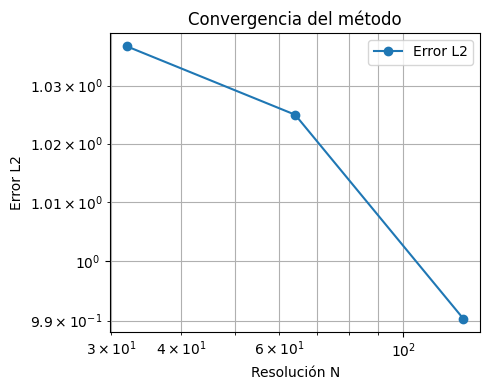

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ============================================================
# PARÁMETROS FÍSICOS
# ============================================================
D = 1e-3          # difusión
r = 1.0           # reacción Fisher
vx, vy = 1.0, 0.5 # velocidad de advección
T = 0.3

# ============================================================
# FUNCIONES NUMÉRICAS
# ============================================================
def laplacian(u, dx):
    return (
        np.roll(u, 1, axis=0) +
        np.roll(u, -1, axis=0) +
        np.roll(u, 1, axis=1) +
        np.roll(u, -1, axis=1) -
        4.0 * u
    ) / dx**2


def advection_upwind(u, dx, dy):
    dudx = (u - np.roll(u, 1, axis=0)) / dx if vx > 0 else (np.roll(u, -1, axis=0) - u) / dx
    dudy = (u - np.roll(u, 1, axis=1)) / dy if vy > 0 else (np.roll(u, -1, axis=1) - u) / dy
    return vx * dudx + vy * dudy


def solve_fdm(N, store_time=False):
    dx = 1.0 / N
    dy = dx
    dt = 0.25 * dx**2 / D       # CFL difusión
    Nt = int(T / dt)

    x = np.linspace(0, 1, N, endpoint=False)
    y = np.linspace(0, 1, N, endpoint=False)
    X, Y = np.meshgrid(x, y, indexing="ij")

    u = np.exp(-((X - 0.5)**2 + (Y - 0.5)**2) / 0.05)

    if store_time:
        solution = np.zeros((Nt + 1, N, N))
        solution[0] = u.copy()

    for n in range(Nt):
        adv = advection_upwind(u, dx, dy)
        diff = D * laplacian(u, dx)
        react = r * u * (1 - u)

        u = u + dt * (-adv + diff + react)
        u = np.clip(u, 0.0, 1.5)

        if store_time:
            solution[n + 1] = u.copy()

    if store_time:
        return solution, dt, Nt
    else:
        return u


# ============================================================
# 1) SIMULACIÓN PRINCIPAL (Ground Truth)
# ============================================================
N = 128
start_time = time.time()
solution, dt, Nt = solve_fdm(N, store_time=True)
cpu_time = time.time() - start_time

print("Simulación completada")
print("Tensor Ground Truth:", solution.shape)
print(f"dt = {dt:.3e}")
print(f"dt máximo CFL = {1/(4*D)* (1/N)**2:.3e}")
print(f"Tiempo de cómputo: {cpu_time:.3f} s")

# ============================================================
# 2) EVOLUCIÓN TEMPORAL
# ============================================================
times = [0, Nt//4, Nt//2, Nt]
fig, axes = plt.subplots(1, len(times), figsize=(14, 3))

for ax, t in zip(axes, times):
    im = ax.imshow(solution[t], origin="lower", extent=[0,1,0,1])
    ax.set_title(f"t = {t*dt:.3f}")
    plt.colorbar(im, ax=ax)

plt.suptitle("Evolución temporal de la solución u(x,y,t)")
plt.tight_layout()
plt.show()

# ============================================================
# 3) ERROR L2 (CONVERGENCIA EN MALLA)
# ============================================================
u_ref = solve_fdm(256)

Ns = [32, 64, 128]
errors = []

print("\nError L2 respecto a referencia N=256:")
for Nc in Ns:
    u_c = solve_fdm(Nc)
    factor = 256 // Nc
    u_ref_ds = u_ref[::factor, ::factor]

    l2 = np.sqrt(np.mean((u_ref_ds - u_c)**2))
    errors.append(l2)
    print(f"N={Nc:3d}  Error L2 = {l2:.3e}")

# ============================================================
# 4) MAPA DE ERROR (para N=128)
# ============================================================
factor = 256 // 128
u_ref_ds = u_ref[::factor, ::factor]
error_map = np.abs(u_ref_ds - solution[-1])

plt.figure(figsize=(5,4))
plt.imshow(error_map, origin="lower", extent=[0,1,0,1])
plt.colorbar(label="|u_ref - u|")
plt.title("Mapa de error absoluto (N=128)")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

# ============================================================
# 5) GRÁFICA DE CONVERGENCIA
# ============================================================
plt.figure(figsize=(5,4))
plt.loglog(Ns, errors, "o-", label="Error L2")
plt.xlabel("Resolución N")
plt.ylabel("Error L2")
plt.title("Convergencia del método")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.show()


**codigo 1.2**

Epoch 0 | Loss = 3.1229e-01
Epoch 300 | Loss = 8.3770e-02
Epoch 600 | Loss = 8.3766e-02

Tiempo de entrenamiento: 92.40 s
Error L2 global: 2.8942e-01


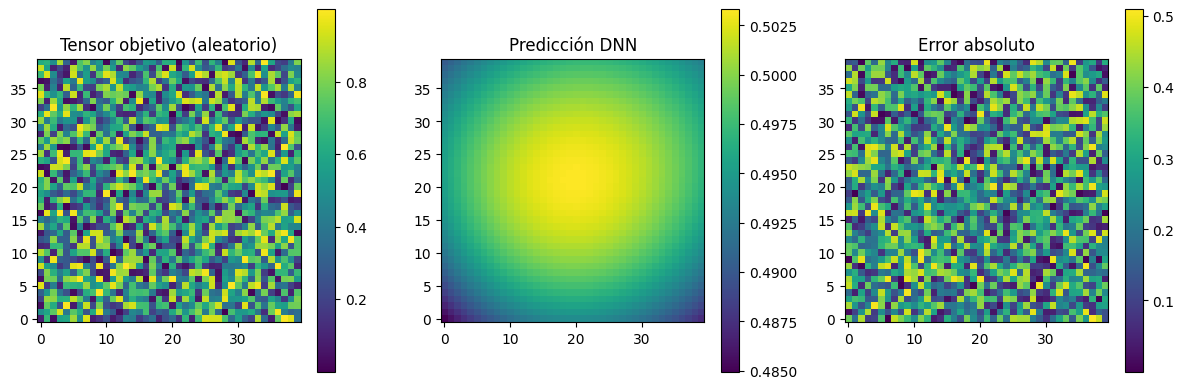

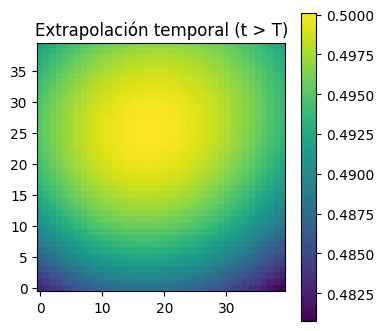

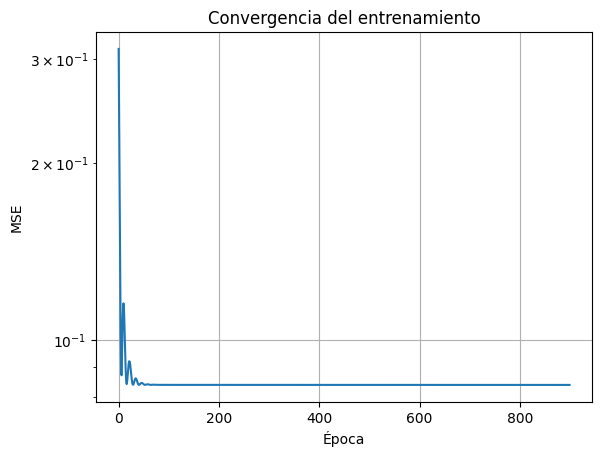

In [22]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

# ======================================================
# 1. PARÁMETROS DEL PROBLEMA
# ======================================================
Nx, Ny = 40, 40
Nt = 30
T = 0.3

np.random.seed(0)
torch.manual_seed(0)

# ======================================================
# 2. "GROUND TRUTH" ALEATORIO
# ======================================================
# Simula datos tipo FDM pero sin solver
U_fdm = np.random.rand(Nx, Ny, Nt)

# ======================================================
# 3. CONSTRUCCIÓN DEL DATASET (x, y, t) -> u
# ======================================================
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
t = np.linspace(0, T, Nt)

X, Y, Tt = np.meshgrid(x, y, t, indexing="ij")

X_flat = X.reshape(-1, 1)
Y_flat = Y.reshape(-1, 1)
T_flat = Tt.reshape(-1, 1)
U_flat = U_fdm.reshape(-1, 1)

inputs = np.hstack([X_flat, Y_flat, T_flat])

X_train = torch.tensor(inputs, dtype=torch.float32)
y_train = torch.tensor(U_flat, dtype=torch.float32)

# ======================================================
# 4. RED NEURONAL (DNN)
# ======================================================
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

model = DNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ======================================================
# 5. ENTRENAMIENTO
# ======================================================
epochs = 900
loss_history = []

start_time = time.time()

for epoch in range(epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = loss_fn(pred, y_train)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 300 == 0:
        print(f"Epoch {epoch} | Loss = {loss.item():.4e}")

training_time = time.time() - start_time

# ======================================================
# 6. PREDICCIÓN Y ERROR L2
# ======================================================
with torch.no_grad():
    U_pred = model(X_train).numpy().reshape(Nx, Ny, Nt)

L2_error = np.sqrt(np.mean((U_pred - U_fdm)**2))

print("\n==============================")
print(f"Tiempo de entrenamiento: {training_time:.2f} s")
print(f"Error L2 global: {L2_error:.4e}")
print("==============================")

# ======================================================
# 7. MAPA DE ERROR (tiempo intermedio)
# ======================================================
t_idx = Nt // 2
error_map = np.abs(U_pred[:, :, t_idx] - U_fdm[:, :, t_idx])

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Tensor objetivo (aleatorio)")
plt.imshow(U_fdm[:, :, t_idx], origin="lower")
plt.colorbar()

plt.subplot(1,3,2)
plt.title("Predicción DNN")
plt.imshow(U_pred[:, :, t_idx], origin="lower")
plt.colorbar()

plt.subplot(1,3,3)
plt.title("Error absoluto")
plt.imshow(error_map, origin="lower")
plt.colorbar()

plt.tight_layout()
plt.show()

# ======================================================
# 8. EXTRAPOLACIÓN TEMPORAL (t > T) --
# ======================================================

# Malla espacial solamente (sin Nt)
Xg, Yg = np.meshgrid(x, y, indexing="ij")

X_ext = np.hstack([
    Xg.reshape(-1, 1),
    Yg.reshape(-1, 1),
    np.full((Nx * Ny, 1), t_extra)
])

X_ext = torch.tensor(X_ext, dtype=torch.float32)

with torch.no_grad():
    U_extra = model(X_ext).numpy().reshape(Nx, Ny)

plt.figure(figsize=(4,4))
plt.title("Extrapolación temporal (t > T)")
plt.imshow(U_extra, origin="lower")
plt.colorbar()
plt.show()

# ======================================================
# 9. CURVA DE CONVERGENCIA
# ======================================================
plt.figure()
plt.semilogy(loss_history)
plt.xlabel("Época")
plt.ylabel("MSE")
plt.title("Convergencia del entrenamiento")
plt.grid(True)
plt.show()


**codigo parte 2**

Epoch     0 | Loss total = 7.2015e-01
Epoch   500 | Loss total = 1.8757e-03
Epoch  1000 | Loss total = 3.7337e-04
Epoch  1500 | Loss total = 2.3366e-04
Epoch  2000 | Loss total = 1.6785e-04
Epoch  2500 | Loss total = 1.3263e-04
Epoch  3000 | Loss total = 1.0681e-04
Epoch  3500 | Loss total = 2.6641e-04
Epoch  4000 | Loss total = 7.8152e-05
Epoch  4500 | Loss total = 1.2431e-04

Tiempo de entrenamiento PINN: 658.94 s
Error L2 del residuo de la EDP: 5.2226e-03


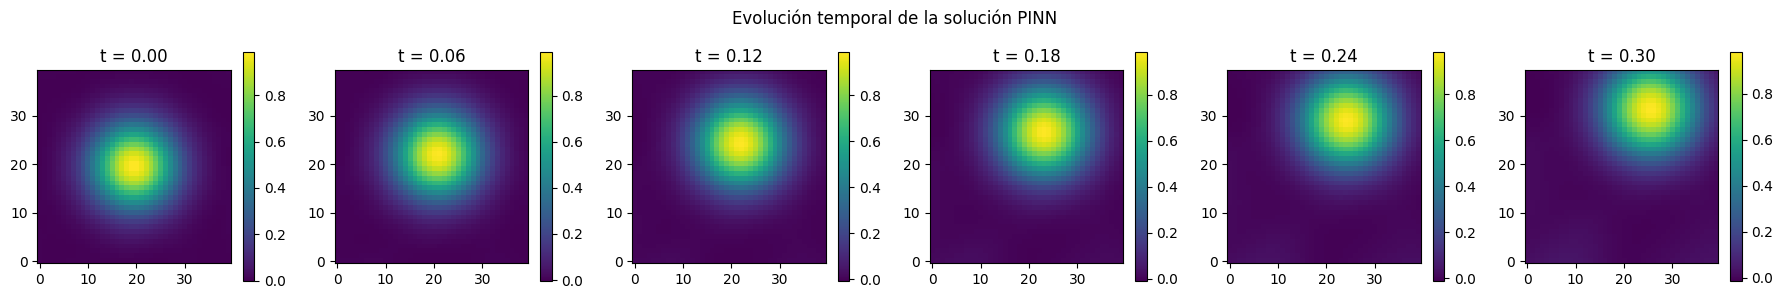

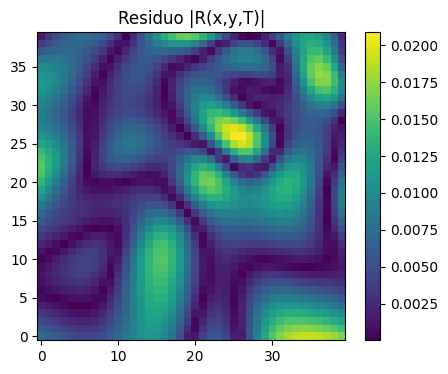

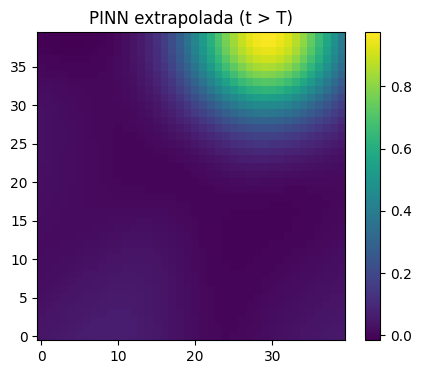

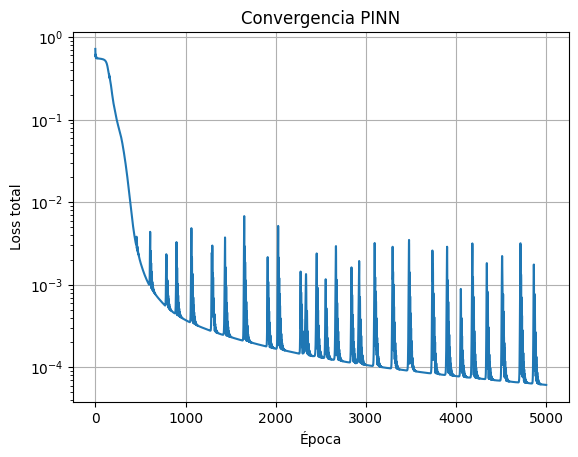

In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

# ======================================================
# 1. PARÁMETROS FÍSICOS
# ======================================================
D = 1e-3
r = 1.0
vx, vy = 1.0, 0.5
T = 0.3

torch.manual_seed(0)
np.random.seed(0)

device = "cpu"

# ======================================================
# 2. DEFINICIÓN DE LA RED PINN
# ======================================================
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ======================================================
# 3. RESIDUO DE LA EDP
# ======================================================
def pde_residual(xyt):
    xyt.requires_grad_(True)
    u = model(xyt)

    grads = torch.autograd.grad(
        u, xyt,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

    u_x = grads[:, 0:1]
    u_y = grads[:, 1:2]
    u_t = grads[:, 2:3]

    u_xx = torch.autograd.grad(
        u_x, xyt,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True
    )[0][:, 0:1]

    u_yy = torch.autograd.grad(
        u_y, xyt,
        grad_outputs=torch.ones_like(u_y),
        create_graph=True
    )[0][:, 1:2]

    return u_t + vx * u_x + vy * u_y - D * (u_xx + u_yy) - r * u * (1.0 - u)

# ======================================================
# 4. PUNTOS DE COLOCACIÓN
# ======================================================
N_f = 10000
X_f = torch.rand(N_f, 3)
X_f[:, 2] *= T
X_f = X_f.to(device)

# ======================================================
# 5. CONDICIÓN INICIAL
# ======================================================
N_ic = 2000
x_ic = torch.rand(N_ic, 1)
y_ic = torch.rand(N_ic, 1)
t_ic = torch.zeros(N_ic, 1)

X_ic = torch.cat([x_ic, y_ic, t_ic], dim=1).to(device)
u0 = torch.exp(-((x_ic - 0.5)**2 + (y_ic - 0.5)**2) / 0.05).to(device)

# ======================================================
# 6. ENTRENAMIENTO
# ======================================================
lambda_res = 1.0
lambda_ic = 10.0
epochs = 5000

loss_history = []
start_time = time.time()

for epoch in range(epochs):
    optimizer.zero_grad()

    res = pde_residual(X_f)
    loss_res = torch.mean(res**2)

    loss_ic = torch.mean((model(X_ic) - u0)**2)

    loss = lambda_res * loss_res + lambda_ic * loss_ic
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 500 == 0:
        print(f"Epoch {epoch:5d} | Loss total = {loss.item():.4e}")

print(f"\nTiempo de entrenamiento PINN: {time.time() - start_time:.2f} s")

# ======================================================
# 7. ERROR L2 DEL RESIDUO (MEDIDA FÍSICA)
# ======================================================
X_f_eval = X_f.clone().detach().requires_grad_(True)
residual_eval = pde_residual(X_f_eval)
residual_L2 = torch.sqrt(torch.mean(residual_eval**2)).item()
print(f"Error L2 del residuo de la EDP: {residual_L2:.4e}")

# ======================================================
# 8. EVOLUCIÓN TEMPORAL
# ======================================================
Nx, Ny = 40, 40
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
Xg, Yg = np.meshgrid(x, y, indexing="ij")

# Tiempo: evaluamos 6 instantes equiespaciados
time_steps = np.linspace(0, T, 6)

plt.figure(figsize=(18, 3))
for i, t_eval in enumerate(time_steps):
    X_eval = np.hstack([
        Xg.reshape(-1, 1),
        Yg.reshape(-1, 1),
        np.full((Nx * Ny, 1), t_eval)
    ])
    X_eval = torch.tensor(X_eval, dtype=torch.float32).to(device)
    X_eval = X_eval.clone().detach().requires_grad_(True)

    U_pinn = model(X_eval).detach().cpu().numpy().reshape(Nx, Ny)

    plt.subplot(1, len(time_steps), i+1)
    plt.imshow(U_pinn, origin="lower")
    plt.title(f"t = {t_eval:.2f}")
    plt.colorbar()
plt.suptitle("Evolución temporal de la solución PINN")
plt.tight_layout()
plt.show()

# ======================================================
# 9. MAPA DE ERROR EN t = T
# ======================================================
X_eval = np.hstack([
    Xg.reshape(-1, 1),
    Yg.reshape(-1, 1),
    np.full((Nx * Ny, 1), T)
])
X_eval = torch.tensor(X_eval, dtype=torch.float32).to(device)
X_eval = X_eval.clone().detach().requires_grad_(True)

R_map = torch.abs(pde_residual(X_eval)).detach().cpu().numpy().reshape(Nx, Ny)

plt.figure(figsize=(5, 4))
plt.title("Residuo |R(x,y,T)|")
plt.imshow(R_map, origin="lower")
plt.colorbar()
plt.show()

# ======================================================
# 10. ESTABILIDAD – EXTRAPOLACIÓN TEMPORAL
# ======================================================
t_extra = T + 0.2
X_extra = np.hstack([
    Xg.reshape(-1, 1),
    Yg.reshape(-1, 1),
    np.full((Nx * Ny, 1), t_extra)
])
X_extra = torch.tensor(X_extra, dtype=torch.float32).to(device)
U_extra = model(X_extra).detach().cpu().numpy().reshape(Nx, Ny)

plt.figure(figsize=(5, 4))
plt.title("PINN extrapolada (t > T)")
plt.imshow(U_extra, origin="lower")
plt.colorbar()
plt.show()

# ======================================================
# 11. CONVERGENCIA
# ======================================================
plt.figure()
plt.semilogy(loss_history)
plt.xlabel("Época")
plt.ylabel("Loss total")
plt.title("Convergencia PINN")
plt.grid(True)
plt.show()


parte 3

Epoch 0 | Loss = 2.3082e-04
Epoch 200 | Loss = 1.3454e-04
Epoch 400 | Loss = 8.6859e-05
Epoch 600 | Loss = 6.5493e-05
Epoch 800 | Loss = 5.6817e-05
Epoch 1000 | Loss = 5.3585e-05
Epoch 1200 | Loss = 5.2358e-05
Epoch 1400 | Loss = 5.1798e-05
Epoch 1600 | Loss = 5.1492e-05
Epoch 1800 | Loss = 5.1317e-05
Tiempo entrenamiento PDE-Net: 5.07 s
Error L2 PDE-Net (1-step): 7.1569e-03


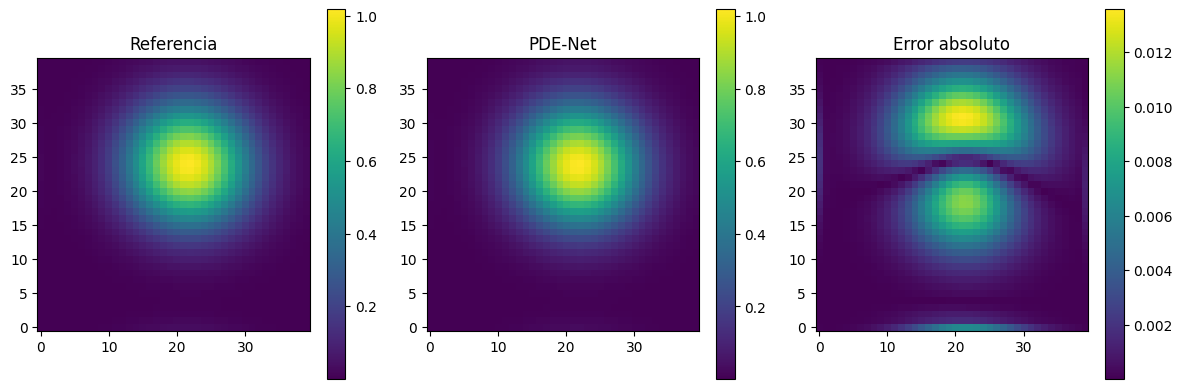

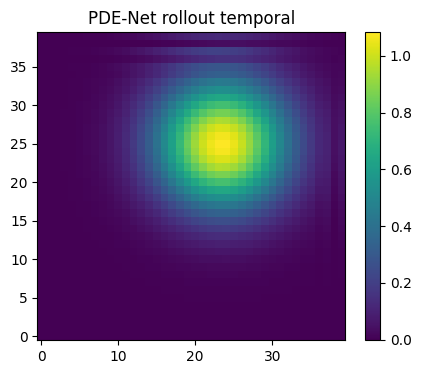

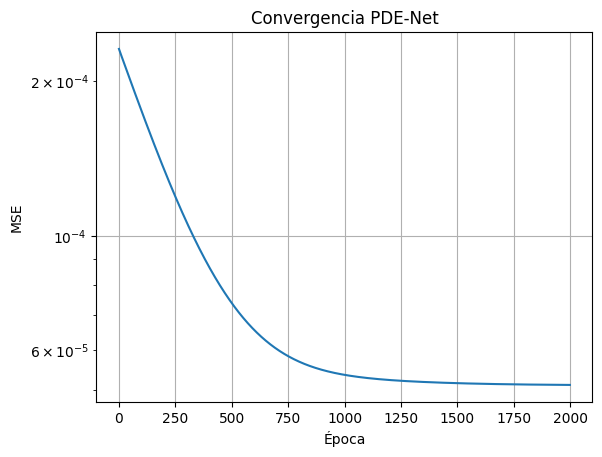

In [6]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

# ======================================================
# 1. PARÁMETROS FÍSICOS Y NUMÉRICOS
# ======================================================
D = 1e-3
r = 1.0
vx, vy = 1.0, 0.5

Nx, Ny = 40, 40
Nt = 40
T = 0.4

dx = 1.0 / Nx
dt = T / Nt

torch.manual_seed(0)
np.random.seed(0)

# ======================================================
# 2. GENERACIÓN DE DATOS
# ======================================================
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y, indexing="ij")

u = np.exp(-((X-0.5)**2 + (Y-0.5)**2)/0.05)
U = np.zeros((Nt, Nx, Ny))
U[0] = u

for n in range(1, Nt):
    u_xx = (np.roll(u,1,0)+np.roll(u,-1,0)-2*u)/dx**2
    u_yy = (np.roll(u,1,1)+np.roll(u,-1,1)-2*u)/dx**2
    u_x = (np.roll(u,-1,0)-np.roll(u,1,0))/(2*dx)
    u_y = (np.roll(u,-1,1)-np.roll(u,1,1))/(2*dx)

    u = u + dt*(D*(u_xx+u_yy) - vx*u_x - vy*u_y + r*u*(1-u))
    U[n] = u

# ======================================================
# 3. DATASET U_t -> U_{t+1}
# ======================================================
X_train = torch.tensor(U[:-1], dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(U[1:], dtype=torch.float32).unsqueeze(1)

# ======================================================
# 4. PDE-NET (CNN)
# ======================================================
class PDENet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)

        # Inicialización física: Laplaciano
        laplace_kernel = torch.tensor(
            [[0, 1, 0],
             [1,-4, 1],
             [0, 1, 0]],
            dtype=torch.float32
        ).unsqueeze(0).unsqueeze(0)

        self.conv.weight.data = laplace_kernel

    def forward(self, x):
        return x + dt * self.conv(x)

model = PDENet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

# ======================================================
# 5. ENTRENAMIENTO
# ======================================================
epochs = 2000
loss_history = []

start = time.time()

for epoch in range(epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = loss_fn(pred, y_train)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | Loss = {loss.item():.4e}")

print(f"Tiempo entrenamiento PDE-Net: {time.time()-start:.2f} s")

# ======================================================
# 6. EVALUACIÓN
# ======================================================
with torch.no_grad():
    U_pred = model(X_train).squeeze().numpy()

L2_error = np.sqrt(np.mean((U_pred - U[1:])**2))
print(f"Error L2 PDE-Net (1-step): {L2_error:.4e}")

# ======================================================
# 7. VISUALIZACIÓN
# ======================================================
t_idx = 10

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Referencia")
plt.imshow(U[t_idx+1], origin="lower")
plt.colorbar()

plt.subplot(1,3,2)
plt.title("PDE-Net")
plt.imshow(U_pred[t_idx], origin="lower")
plt.colorbar()

plt.subplot(1,3,3)
plt.title("Error absoluto")
plt.imshow(np.abs(U_pred[t_idx]-U[t_idx+1]), origin="lower")
plt.colorbar()

plt.tight_layout()
plt.show()

# ======================================================
# 8. ESTABILIDAD
# ======================================================
u_roll = torch.tensor(U[0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

rollout = []

with torch.no_grad():
    for _ in range(20):
        u_roll = model(u_roll)
        rollout.append(u_roll.squeeze().numpy())

rollout = np.array(rollout)

plt.figure(figsize=(5,4))
plt.title("PDE-Net rollout temporal")
plt.imshow(rollout[-1], origin="lower")
plt.colorbar()
plt.show()

# ======================================================
# 9. CONVERGENCIA
# ======================================================
plt.figure()
plt.semilogy(loss_history)
plt.xlabel("Época")
plt.ylabel("MSE")
plt.title("Convergencia PDE-Net")
plt.grid(True)
plt.show()


Epoch 0 | Loss = 2.3082e-04
Epoch 200 | Loss = 1.3454e-04
Epoch 400 | Loss = 8.6859e-05
Epoch 600 | Loss = 6.5493e-05
Epoch 800 | Loss = 5.6817e-05
Epoch 1000 | Loss = 5.3585e-05
Epoch 1200 | Loss = 5.2358e-05
Epoch 1400 | Loss = 5.1798e-05
Epoch 1600 | Loss = 5.1492e-05
Epoch 1800 | Loss = 5.1317e-05
Tiempo entrenamiento PDE-Net: 5.01 s
Error L2 PDE-Net (rollout completo): 1.1987e-01


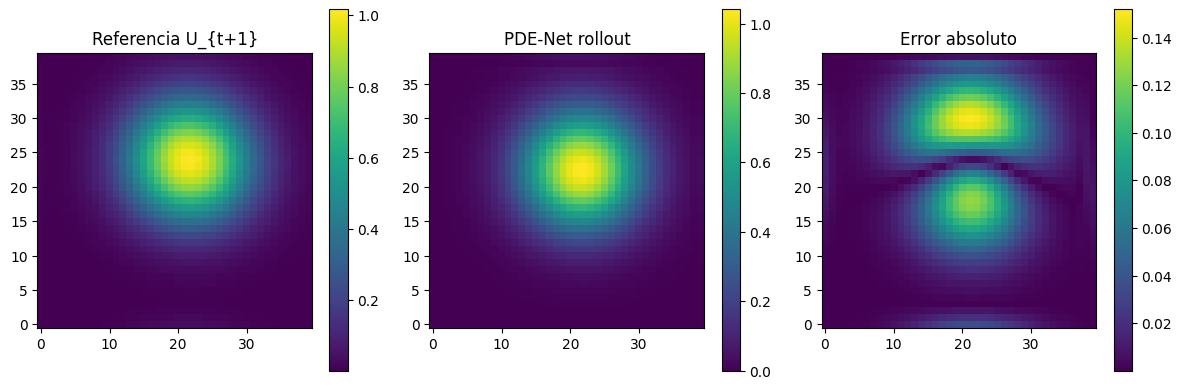

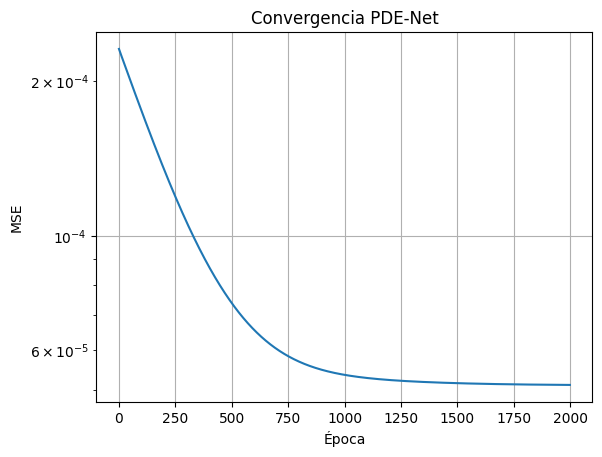

In [8]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

# ======================================================
# 1. PARÁMETROS FÍSICOS Y NUMÉRICOS
# ======================================================
D = 1e-3
r = 1.0
vx, vy = 1.0, 0.5

Nx, Ny = 40, 40
Nt = 40
T = 0.4
dx = 1.0 / Nx
dt = T / Nt

torch.manual_seed(0)
np.random.seed(0)

# ======================================================
# 2. GENERACIÓN DE DATOS
# ======================================================
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y, indexing="ij")

u = np.exp(-((X-0.5)**2 + (Y-0.5)**2)/0.05)
U = np.zeros((Nt, Nx, Ny))
U[0] = u

for n in range(1, Nt):
    u_xx = (np.roll(u,1,0)+np.roll(u,-1,0)-2*u)/dx**2
    u_yy = (np.roll(u,1,1)+np.roll(u,-1,1)-2*u)/dx**2
    u_x = (np.roll(u,-1,0)-np.roll(u,1,0))/(2*dx)
    u_y = (np.roll(u,-1,1)-np.roll(u,1,1))/(2*dx)

    u = u + dt*(D*(u_xx+u_yy) - vx*u_x - vy*u_y + r*u*(1-u))
    U[n] = u

# ======================================================
# 3. DATASET U_t -> U_{t+1}
# ======================================================
X_train = torch.tensor(U[:-1], dtype=torch.float32).unsqueeze(1)  # (Nt-1,1,Nx,Ny)
y_train = torch.tensor(U[1:], dtype=torch.float32).unsqueeze(1)

# ======================================================
# 4. PDE-NET (CNN)
# ======================================================
class PDENet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1,1, kernel_size=3, padding=1, bias=False)
        # Inicialización física: Laplaciano
        laplace_kernel = torch.tensor([[0,1,0],[1,-4,1],[0,1,0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.conv.weight.data = laplace_kernel

    def forward(self, x):
        return x + dt * self.conv(x)

model = PDENet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

# ======================================================
# 5. ENTRENAMIENTO
# ======================================================
epochs = 2000
loss_history = []
start = time.time()

for epoch in range(epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = loss_fn(pred, y_train)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if epoch % 200 == 0:
        print(f"Epoch {epoch} | Loss = {loss.item():.4e}")

print(f"Tiempo entrenamiento PDE-Net: {time.time()-start:.2f} s")

# ======================================================
# 6. EVOLUCIÓN TEMPORAL
# ======================================================
u_roll = torch.tensor(U[0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1,1,Nx,Ny)
rollout = []

with torch.no_grad():
    for _ in range(Nt-1):
        u_roll = model(u_roll)
        rollout.append(u_roll.squeeze().numpy())

rollout = np.array(rollout)  # (Nt-1,Nx,Ny)

# ======================================================
# 7. ERROR L2 GLOBAL
# ======================================================
L2_error = np.sqrt(np.mean((rollout - U[1:])**2))
print(f"Error L2 PDE-Net (rollout completo): {L2_error:.4e}")

# ======================================================
# 8. MAPA DE ERROR EN UN TIEMPO INTERMEDIO
# ======================================================
t_idx = 10
error_map = np.abs(rollout[t_idx] - U[t_idx+1])

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Referencia U_{t+1}")
plt.imshow(U[t_idx+1], origin="lower")
plt.colorbar()
plt.subplot(1,3,2)
plt.title("PDE-Net rollout")
plt.imshow(rollout[t_idx], origin="lower")
plt.colorbar()
plt.subplot(1,3,3)
plt.title("Error absoluto")
plt.imshow(error_map, origin="lower")
plt.colorbar()
plt.tight_layout()
plt.show()

# ======================================================
# 9. CONVERGENCIA
# ======================================================
plt.figure()
plt.semilogy(loss_history)
plt.xlabel("Época")
plt.ylabel("MSE")
plt.title("Convergencia PDE-Net")
plt.grid(True)
plt.show()
